<a href="https://colab.research.google.com/github/ketanp23/pgpmciclass/blob/main/MLflow_Tracking_with_a_Scikit_Learn_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install MLflow and scikit-learn (Colab usually has pandas/matplotlib)
!pip install mlflow==2.16.0 scikit-learn pandas matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 508.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.9 MB/s eta 0:00:00


In [2]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create or set an MLflow experiment
mlflow.set_experiment("Iris_Classification_Colab_Demo")

print("MLflow version:", mlflow.__version__)
print("Experiment set: Iris_Classification_Colab_Demo")

2025/12/27 09:10:38 INFO mlflow.tracking.fluent: Experiment with name 'Iris_Classification_Colab_Demo' does not exist. Creating a new experiment.


MLflow version: 2.16.0
Experiment set: Iris_Classification_Colab_Demo


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa



Class distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


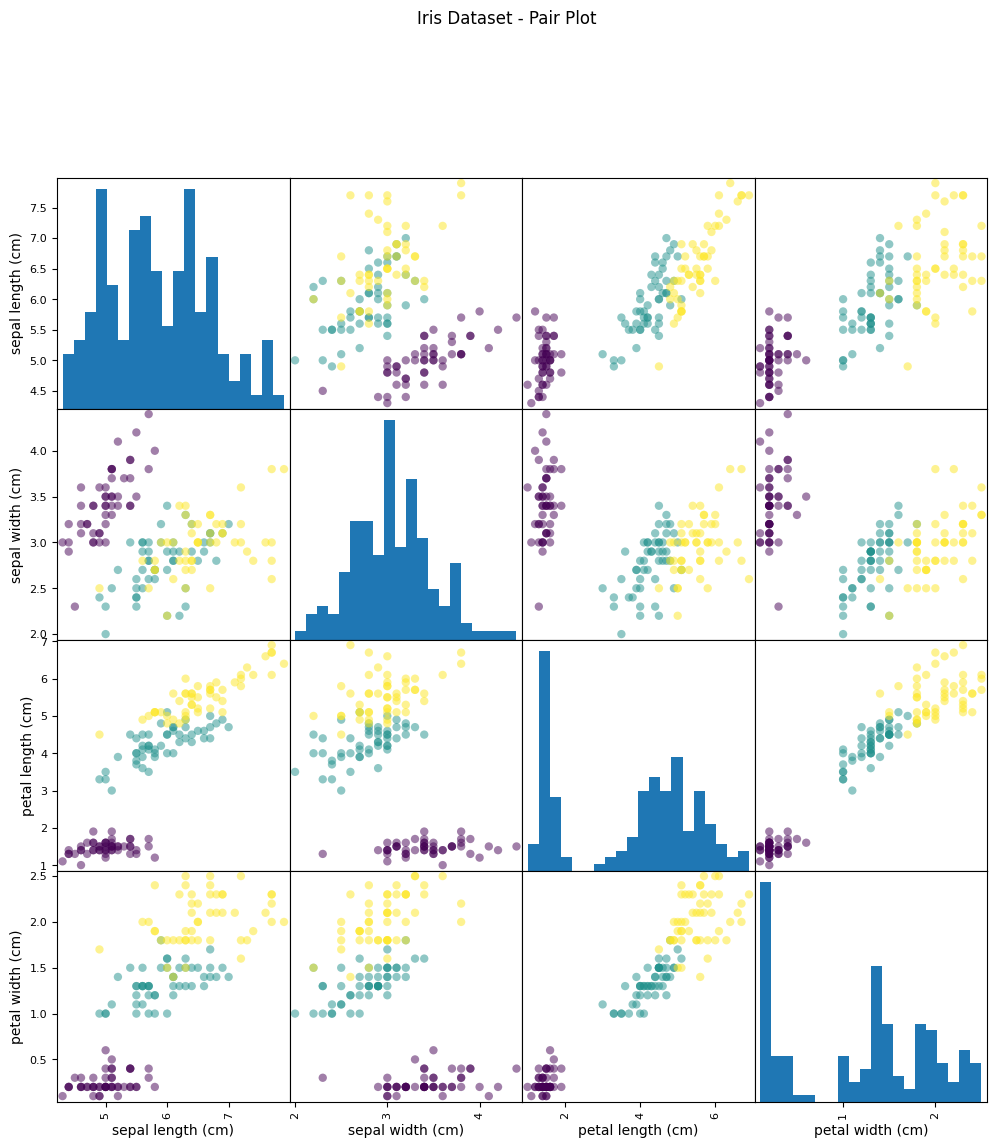

In [3]:
# Load data
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['species'] = df['target'].apply(lambda x: iris.target_names[x])

# Display first rows and class distribution
display(df.head())
print("\nClass distribution:")
print(df['species'].value_counts())

# Simple visualization
pd.plotting.scatter_matrix(df[iris.feature_names], c=iris.target, figsize=(12, 12), marker='o', hist_kwds={'bins': 20})
plt.suptitle("Iris Dataset - Pair Plot", y=1.02)
plt.show()

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=42
)

# Start an MLflow run
with mlflow.start_run(run_name="Manual_RF_Baseline"):
    # Model training
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predictions and evaluation
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    # Log parameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 4)
    mlflow.log_param("random_state", 42)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)

    # Log classification report as artifact
    report = classification_report(y_test, predictions, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")

    # Log the model with input/output signature
    signature = infer_signature(X_test, predictions)
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="random_forest_model",
        signature=signature,
        registered_model_name="IrisRandomForest"  # Optional: registers in Model Registry
    )

    print(f"✅ Manual run completed! Accuracy: {accuracy:.4f}")
    print(f"Run ID: {mlflow.active_run().info.run_id}")

✅ Manual run completed! Accuracy: 1.0000
Run ID: f16ea39939d1459a8062d687d736da37


Successfully registered model 'IrisRandomForest'.
Created version '1' of model 'IrisRandomForest'.


In [5]:
# Enable autologging for scikit-learn (automatically logs params, metrics, model)
mlflow.sklearn.autolog(log_models=True, log_input_examples=True)

with mlflow.start_run(run_name="Autolog_RF_Experiment"):
    model_auto = RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=123
    )
    model_auto.fit(X_train, y_train)

    preds_auto = model_auto.predict(X_test)
    acc_auto = accuracy_score(y_test, preds_auto)

    print(f"✅ Autolog run completed! Accuracy: {acc_auto:.4f}")

2025/12/27 09:11:46 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.6.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


✅ Autolog run completed! Accuracy: 1.0000


In [1]:
# Start MLflow UI in background and tunnel it using ngrok (public URL)
!pip install pyngrok -q

from pyngrok import ngrok
import time

from google.colab import userdata


# Kill any existing ngrok tunnels
ngrok.kill()

#set authenticaltion token
ngrok.set_auth_token(userdata.get('ngroktoken'))

# Start MLflow server in background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Wait a moment for server to start
time.sleep(3)

# Create public tunnel
public_url = ngrok.connect(5000)
print("🚀 MLflow Tracking UI is now available at:")
print(public_url)
print("\nClick the link above to view your experiments, compare runs, and download artifacts!")

🚀 MLflow Tracking UI is now available at:
NgrokTunnel: "https://reformed-dumpily-keren.ngrok-free.dev" -> "http://localhost:5000"

Click the link above to view your experiments, compare runs, and download artifacts!


In [6]:
import mlflow.sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load data and perform train-test split to ensure X_test and y_test are defined
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.5, random_state=42
)

# Get the last run ID (or copy from the UI)
# You can find it printed above or in the UI

# Example: Load the model from the manual run
# Replace <run_id> with the actual ID from Cell 4 output
# Or use the latest registered model

# Option 1: Load from registered model (if you registered it)
try:
    loaded_model = mlflow.sklearn.load_model("models:/IrisRandomForest/latest")
    print("Loaded latest registered model version")
except:
    print("No registered model found, loading from run instead")

# Option 2: Load from a specific run (uncomment and replace run_id)
# run_id = "YOUR_RUN_ID_HERE"  # e.g., from Cell 4 print
# loaded_model = mlflow.sklearn.load_model(f"runs:/{run_id}/random_forest_model")

# Make predictions on sample data
sample_data = X_test[:5]
sample_predictions = loaded_model.predict(sample_data)

print("\nSample Predictions:")
print(sample_predictions)
print("Actual Labels:    ", y_test[:5])

Loaded latest registered model version

Sample Predictions:
[1 0 2 1 1]
Actual Labels:     [1 0 2 1 1]


/usr/local/lib/python3.12/dist-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [9]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

# set the experiment id
mlflow.set_experiment(experiment_id="298549757753390383")

mlflow.autolog()
db = load_diabetes()

X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

# Create and train models.
rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=3)
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = rf.predict(X_test)

2025/12/27 14:03:02 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.6.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/12/27 14:03:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/12/27 14:03:02 WARNING mlflow.utils.autologging_utils: MLflow spark autologging is known to be compatible with 3.1.2 <= pyspark <= 3.5.2, but the installed version is 4.0.1. If you encounter errors during autologging, try upgrading / downgrading pyspark to a compatible version, or try upgrading MLflow.
2025/12/27 14:03:02 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/12/27 14:03:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2025/12/27 14